In [1]:
import pandas as pd
import qe.myqengine as qe

In [12]:
univ = qe.IdUniverse(ids= ['AAPL-US'])
df = qe.calculate(universe=univ,dates = qe.TimeSeries(start_date = '0D'),formulas =['P_OPT_OPTION_CHAIN(#DATE)'],is_array_return_type=True,source='FqlExpression').data
df

,DATE,UNIVERSE,P_OPT_OPTION_CHAIN(#DATE)
0,20230831,AAPL-US,"[AAPL.US#C045P, AAPL.US#C0FVT, AAPL.US#C17SD, ..."


In [13]:
df = df.rename(columns = {'P_OPT_OPTION_CHAIN(#DATE)':'opt_chain',
                          'DATE':'date',
                          'UNIVERSE':'symbol'})

In [19]:
df = df.set_index(['date','symbol'])

In [20]:
#expand out options chain and reindex by date,option id
df_opts= pd.DataFrame(df.opt_chain.explode().reset_index()).set_index(['date','opt_chain'])
df_opts

symbol
date     opt_chain             
20230831 AAPL.US#C045P  AAPL-US
         AAPL.US#C0FVT  AAPL-US
         AAPL.US#C17SD  AAPL-US
         AAPL.US#C1YCP  AAPL-US
         AAPL.US#C281K  AAPL-US
...                         ...
         AAPL.US#PVGJ9  AAPL-US
         AAPL.US#PVMHW  AAPL-US
         AAPL.US#PXDM7  AAPL-US
         AAPL.US#PXTLC  AAPL-US
         AAPL.US#PY34Q  AAPL-US

[1902 rows x 1 columns]

In [25]:
#option univ
opt_univ = qe.IdUniverse(df_opts.index.get_level_values(1).to_list())

# create a FQL object
fql_data = qe.calculate(universe=opt_univ,
                        dates = qe.TimeSeries(start_date = '0D'),
                        source = 'FqlExpression',
               formulas=['P_OPT_STYLE(#DATE)','P_OPT_CALL_OR_PUT(#DATE)','P_OPT_EXP_DATEN(#DATE)','P_OPT_CLOSE_PRICE(#DATE)','P_OPT_STRIKE_PRICE(#DATE)','P_OPT_IMPV(#DATE)'])

In [26]:
df_f = fql_data.data

In [29]:
df_f = df_f.rename(columns ={"DATE":'date',
                            "UNIVERSE":'opt_chain',})

In [32]:
#join parent tickers
df_final = df_f.set_index(['date','opt_chain']).join(df_opts['symbol'], how = 'left')

df_final.tail(10)

P_OPT_STYLE(#DATE)  P_OPT_CALL_OR_PUT(#DATE)  \
date     opt_chain                                                     
20230831 AAPL.US#PRXM6                 0.0                       1.0   
         AAPL.US#PT22Y                 0.0                       1.0   
         AAPL.US#PT30P                 0.0                       1.0   
         AAPL.US#PTSK7                 0.0                       1.0   
         AAPL.US#PV7DG                 0.0                       1.0   
         AAPL.US#PVGJ9                 0.0                       1.0   
         AAPL.US#PVMHW                 0.0                       1.0   
         AAPL.US#PXDM7                 0.0                       1.0   
         AAPL.US#PXTLC                 0.0                       1.0   
         AAPL.US#PY34Q                 0.0                       1.0   

                        P_OPT_EXP_DATEN(#DATE)  P_OPT_CLOSE_PRICE(#DATE)  \
date     opt_chain                                                         
20230831 AAPL.US#PRXM6              20231013.0                      0.12   
         AAPL.US#PT22Y              20231013.0                      0.00   
         AAPL.US#PT30P              20231013.0                      0.07   
         AAPL.US#PTSK7              20231013.0                      8.31   
         AAPL.US#PV7DG              20231013.0                     12.30   
         AAPL.US#PVGJ9              20230908.0                      0.00   
         AAPL.US#PVMHW              20231013.0                      0.00   
         AAPL.US#PXDM7              20230915.0                      0.00   
         AAPL.US#PXTLC              20231013.0                      0.00   
         AAPL.US#PY34Q              20231013.0                      0.27   

                        P_OPT_STRIKE_PRICE(#DATE)  P_OPT_IMPV(#DATE)   symbol  
date     opt_chain                                                             
20230831 AAPL.US#PRXM6                      140.0          40.223432  AAPL-US  
         AAPL.US#PT22Y                      205.0          30.622425  AAPL-US  
         AAPL.US#PT30P                      135.0          43.042785  AAPL-US  
         AAPL.US#PTSK7                      195.0          20.567783  AAPL-US  
         AAPL.US#PV7DG                      200.0          19.960178  AAPL-US  
         AAPL.US#PVGJ9                      212.5          45.510596  AAPL-US  
         AAPL.US#PVMHW                      250.0          67.596758  AAPL-US  
         AAPL.US#PXDM7                      212.5          43.233227  AAPL-US  
         AAPL.US#PXTLC                      240.0          59.721253  AAPL-US  
         AAPL.US#PY34Q                      155.0          54.013895  AAPL-US

C:\Users\nurciuoli\AppData\Local\Temp\1\ipykernel_16876\1773208059.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_final[df_final['symbol']=='AAPL-US'].groupby(['P_OPT_EXP_DATEN(#DATE)','P_OPT_CALL_OR_PUT(#DATE)']).median()['P_OPT_IMPV(#DATE)'].unstack().plot()


<Axes: xlabel='P_OPT_EXP_DATEN(#DATE)'>

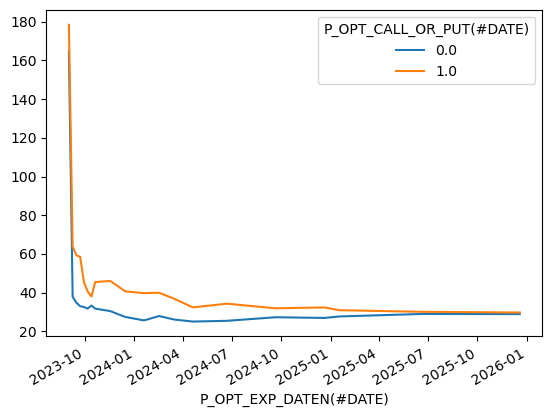

In [36]:
#convert date to datetime
df_final['P_OPT_EXP_DATEN(#DATE)'] = pd.to_datetime(df_final['P_OPT_EXP_DATEN(#DATE)'], format='%Y%m%d')
#plot CAT
df_final[df_final['symbol']=='AAPL-US'].groupby(['P_OPT_EXP_DATEN(#DATE)','P_OPT_CALL_OR_PUT(#DATE)']).median()['P_OPT_IMPV(#DATE)'].unstack().plot()